# Data exploration

In [1]:
import pandas as pd
import os

In [2]:
file_list=['spy/'+i for i in os.listdir('spy')]

In [3]:
sample = pd.read_csv(file_list[0])

In [4]:
sample

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1378238400,2013-09-03 16:00,2013-09-03,16.0,164.34,2013-09-06,1378497600,3.00,1.000000,0.000000,...,0.000000,-0.001900,0.000460,0.001270,-0.003840,0.000000,0.643160,,29.3,0.179
1,1378238400,2013-09-03 16:00,2013-09-03,16.0,164.34,2013-09-06,1378497600,3.00,1.000000,0.000000,...,0.000000,-0.001130,0.000500,0.000830,-0.004090,0.000000,0.631860,,28.8,0.175
2,1378238400,2013-09-03 16:00,2013-09-03,16.0,164.34,2013-09-06,1378497600,3.00,0.992500,0.001610,...,0.000000,-0.001890,0.000530,0.000610,-0.004340,0.000000,0.620190,,28.3,0.172
3,1378238400,2013-09-03 16:00,2013-09-03,16.0,164.34,2013-09-06,1378497600,3.00,0.955200,0.005090,...,0.000000,-0.001480,0.000490,0.000660,-0.004090,-0.000160,0.609250,,27.8,0.169
4,1378238400,2013-09-03 16:00,2013-09-03,16.0,164.34,2013-09-06,1378497600,3.00,0.958500,0.005010,...,0.000000,-0.001640,0.000500,0.000640,-0.003740,0.000000,0.598860,,27.3,0.166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29510,1380571200,2013-09-30 16:00,2013-09-30,16.0,167.99,2015-12-19,1450558800,810.04,0.111160,0.004110,...,0.000000,-0.964860,0.000000,0.000000,-0.006530,-5.216610,0.000050,,67.0,0.399
29511,1380571200,2013-09-30 16:00,2013-09-30,16.0,167.99,2015-12-19,1450558800,810.04,0.112980,0.003920,...,0.000000,-0.965660,0.000000,0.000000,-0.006930,-5.327630,0.000470,,72.0,0.429
29512,1380571200,2013-09-30 16:00,2013-09-30,16.0,167.99,2015-12-19,1450558800,810.04,0.095330,0.003520,...,0.000000,-0.964840,0.000000,0.000000,-0.006640,-5.439200,-0.000250,,77.0,0.458
29513,1380571200,2013-09-30 16:00,2013-09-30,16.0,167.99,2015-12-19,1450558800,810.04,0.111750,0.003560,...,0.000000,-0.965280,0.000000,0.000000,-0.007190,-5.549450,-0.000080,,82.0,0.488


In [5]:
sample[' [P_THETA]'].count()

29515

In [6]:
sample_dropna=sample[' [P_THETA]'].value_counts().dropna()
sample_dropna.count()

5653

In [7]:
sample_dropna=sample_dropna[2:]

In [8]:
sample_dropna.count()

5651

<AxesSubplot: >

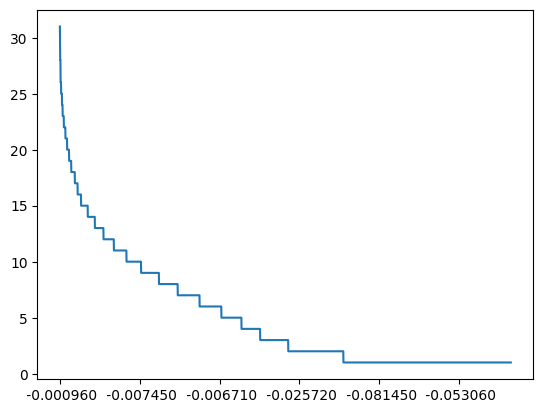

In [9]:
sample_dropna.plot()

In [11]:
#examing all csv's columns match
csv_cloumns=[]
for i in file_list:
    sample = pd.read_csv(i, nrows=1, low_memory=False)
    csv_cloumns.append(sample.columns)
    
import itertools
for a, b in itertools.combinations(csv_cloumns, 2):
    if (a==b).all(): pass
    else: print('false')

In [12]:
file_list=['spx/'+i for i in os.listdir('spx')]

In [13]:
sample = pd.read_csv(file_list[0])

In [14]:
sample

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1580763600,2020-02-03 16:00,2020-02-03,16.0,3248.65,2020-02-03,1580763600,0.0,0.99346,0.00002,...,0.07,-0.00018,0.0,0.00158,-0.02552,-0.00034,2.685290,,1248.7,0.384
1,1580763600,2020-02-03 16:00,2020-02-03,16.0,3248.65,2020-02-03,1580763600,0.0,0.99321,0.00006,...,0.10,-0.00032,0.0,0.00143,-0.02513,0.00000,2.429650,26.000000,1148.7,0.354
2,1580763600,2020-02-03 16:00,2020-02-03,16.0,3248.65,2020-02-03,1580763600,0.0,0.99251,0.00006,...,0.10,-0.00015,0.0,0.00130,-0.02463,0.00000,2.304530,14.000000,1098.7,0.338
3,1580763600,2020-02-03 16:00,2020-02-03,16.0,3248.65,2020-02-03,1580763600,0.0,0.99183,0.00006,...,0.05,-0.00073,0.0,0.00210,-0.02493,0.00000,2.183160,10.000000,1048.7,0.323
4,1580763600,2020-02-03 16:00,2020-02-03,16.0,3248.65,2020-02-03,1580763600,0.0,0.99283,0.00002,...,0.15,-0.00029,0.0,0.00198,-0.02515,0.00000,2.064490,19.000000,998.7,0.307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132831,1582923600,2020-02-28 16:00,2020-02-28,16.0,2956.69,2022-12-16,1671224400,1022.0,0.03202,0.00012,...,1119.61,-0.93895,0.0,0.00000,-0.17034,-126.00439,0.000340,1.000000,1543.3,0.522
132832,1582923600,2020-02-28 16:00,2020-02-28,16.0,2956.69,2022-12-16,1671224400,1022.0,0.03021,0.00006,...,0.00,-1.00000,0.0,-16443.10040,0.00000,0.00000,,,1643.3,0.556
132833,1582923600,2020-02-28 16:00,2020-02-28,16.0,2956.69,2022-12-16,1671224400,1022.0,0.02299,0.00006,...,0.00,-1.00000,0.0,-17443.10024,0.00000,0.00000,,,1743.3,0.590
132834,1582923600,2020-02-28 16:00,2020-02-28,16.0,2956.69,2022-12-16,1671224400,1022.0,0.02147,0.00004,...,0.00,-1.00000,0.0,-18443.10002,0.00000,0.00000,,,1843.3,0.623


In [15]:
sample[' [P_THETA]'].count().sum()

132836

In [16]:
sample_dropna=sample[' [P_THETA]'].value_counts().dropna()
sample_dropna.count()

69035

In [17]:
sample_dropna=sample_dropna.iloc[1:]

In [29]:
sample_dropna

-0.02511    36
-0.02500    36
-0.02475    34
-0.02525    34
-0.02517    33
            ..
-1.53069     1
-1.76821     1
-2.01840     1
-2.31320     1
-0.17937     1
Name:  [P_THETA], Length: 69034, dtype: int64

In [35]:
sample_dropna.sort_index()

-23.49040    1
-23.49018    1
-23.09008    1
-23.04046    1
-23.04036    1
            ..
-0.00028     1
-0.00016     1
-0.00015     1
-0.00012     1
-0.00011     1
Name:  [P_THETA], Length: 69034, dtype: int64

In [ ]:
# data is obnormal with theta more than 20

In [38]:
sample_dropna[sample_dropna.index>-1]

-0.02511    36
-0.02500    36
-0.02475    34
-0.02525    34
-0.02517    33
            ..
-0.54289     1
-0.62352     1
-0.74008     1
-0.90740     1
-0.17937     1
Name:  [P_THETA], Length: 56246, dtype: int64

In [19]:
sample_dropna.count()

69034

In [20]:
sample_dropna.index.min()

-23.4904

<AxesSubplot: >

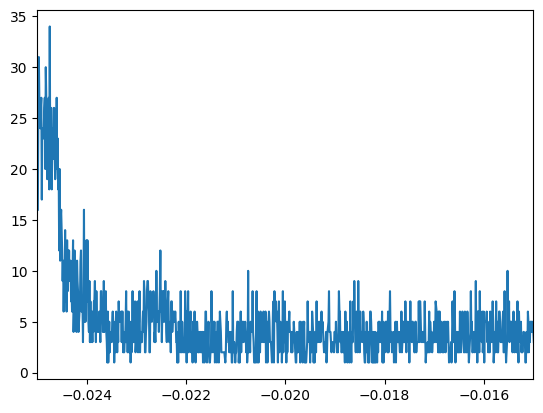

In [47]:
sample_dropna[sample_dropna.index>-.025].sort_index().plot(xlim=(-0.025,-0.015))

In [49]:
#examing all csv's columns match
csv_cloumns=[]
for i in file_list:
    sample = pd.read_csv(i, nrows=1, low_memory=False)
    csv_cloumns.append(sample.columns)
    
import itertools
for a, b in itertools.combinations(csv_cloumns, 2):
    if (a==b).all(): pass
    else: print('false')